In [1]:
import pandas as pd
import konlpy
import gensim

## 데이터 불러오기
- Train, Test 데이터

In [3]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [4]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [172]:
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

## Train 데이터 분석

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


#### info 메소드로 확인 결과
- 총 150000 데이터 중 document는 149995로 확인
- 결측치가 있는지 확인

In [19]:
# train데이터 중 document에 결측치가 있는지 확인
train_data[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [27]:
# 각각 확인해보기
train_data[train_data['id'].isnull()], train_data[train_data['label'].isnull()], train_data[train_data['document'].isnull()]

(Empty DataFrame
 Columns: [id, document, label]
 Index: [],
 Empty DataFrame
 Columns: [id, document, label]
 Index: [],
              id document  label
 25857   2172111      NaN      1
 55737   6369843      NaN      1
 110014  1034280      NaN      0
 126782  5942978      NaN      0
 140721  1034283      NaN      0)

In [30]:
# 중복 확인 3817개
train_data[train_data['document'].duplicated()]

,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1
...,...,...,...
149919,6502490,짱,1
149949,3924716,OO 영화,0
149960,6368431,지루하다,0
149966,6735753,1,0


## 형태소 사전과 인코더-디코더 만들기
 
> KoNLPy의 형태소 분석 종류 ([🔗](https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html))
> - Hannanum: 한나눔. KAIST Semantic Web Research Center 개발.
    - http://semanticweb.kaist.ac.kr/hannanum/
> - Kkma: 꼬꼬마. 서울대학교 IDS(Intelligent Data Systems) 연구실 개발.
    - http://kkma.snu.ac.kr/
> - Komoran: 코모란. Shineware에서 개발.
    - https://github.com/shin285/KOMORAN
> - Mecab: 메카브. 일본어용 형태소 분석기를 한국어를 사용할 수 있도록 수정.
    - https://bitbucket.org/eunjeon/mecab-ko
> - Open Korean Text: 오픈 소스 한국어 분석기. 과거 트위터 형태소 분석기.
    - https://github.com/open-korean-text/open-korean-text

#### 형태소 분석 선택 및 중복, 결측치 제거

In [7]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [53]:
# mecab 형태소 분석기 사용
# 불용어 정의
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [54]:
# drop_duplicates : 중복값 제거 (결측치 중복 포함 : 3817)
# dropna : 결측치 제거 (중복 제거 후 남은 결측치 : 1)
# 15000 - 3817 -1 = 146182
train_data_nonNa = train_data.drop_duplicates(subset=['document'])
train_data_nonNa = train_data_nonNa.dropna(how = 'any')
train_data_nonNa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


#### token화 및 불용어 처리

In [114]:
# tokenizer 처리 예시
def sentence2token(sentence):
    token = tokenizer.morphs(sentence)
    print('기본 : {}'.format(sentence))
    print('token화 : {}'.format(token))
    return token

# train에서 문장 하나 가져오기
sentence_num = 0
# token 생성
temp = sentence2token(sentence=train_data_nonNa.loc[sentence_num,"document"])
# 불용어 처리
temp = [word for word in temp if not word in stopwords]
print(f'불용어 처리 : {temp}')

기본 : 아 더빙.. 진짜 짜증나네요 목소리
token화 : ['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']
불용어 처리 : ['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']


In [87]:
# train에 있는 모든 문장을 토큰화 및 불용어 제거 후 토큰 리스트 생성
X_train = []
for sentence in train_data_nonNa['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [88]:
# 토큰 리스트
print(X_train[:3])

[['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '.', '..', '포스터', '보고', '초딩', '영화', '줄', '.', '...', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


#### 사전 정의

In [89]:
# X_train은 각 document에 존재하는 토큰이 리스트로 한차례 더 나눠져 있음 (2차원)
# 각 리스트에 존재하는 토큰을 하나의 리스트로 결합
words = np.concatenate(X_train).tolist()
print(len(words))

2336238


In [90]:
# list -> dict
counter = Counter(words)
print(len(counter))

53961


In [91]:
# 가장 많이 사용된 순으로 9996개 추출
counter = counter.most_common(10000-4)
print(len(counter))

9996


In [104]:
# 앞에 4개의 빈 원소가 있는 리스트를 추가
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
print(vocab)

['<PAD>', '<BOS>', '<UNK>', '<UNUSED>', '.', '영화', '다', '고', '하', '을', '보', '..', '게', ',', '!', '지', '있', '없', '?', '좋', '나', '었', '만', '는데', '너무', '봤', '적', '안', '정말', '로', '음', '것', '아', '네요', '재밌', '어', '같', '점', '지만', '진짜', '했', '에서', '기', '네', '않', '거', '았', '수', '되', '면', 'ㅋㅋ', '말', '연기', '인', '주', '내', '최고', '~', '평점', '이런', '던', '어요', '할', '왜', '겠', '1', '스토리', '해', '습니다', 'ㅋㅋㅋ', '...', '드라마', '생각', '아니', '더', '그', '싶', '사람', '듯', '때', '감동', '함', '배우', '본', '까지', '뭐', '알', '만들', '내용', '볼', '감독', '보다', '라', '그냥', '재미', '시간', '지루', '중', '재미있', '년', '10', '였', '잼', '사랑', '못', '냐', '재미없', '쓰레기', '서', '2', '라고', '야', '니', '면서', '번', '다시', '나오', '작품', '이거', '하나', '줄', '해서', '개', '남', '정도', '마지막', '끝', '이건', '액션', '임', 'ㅋ', '3', '기대', '입니다', '건', '라는', '분', '완전', '다는', '참', '많', '처음', '장면', '대', '아깝', '다가', '으면', '지금', '모르', '이렇게', "'", '편', '일', '돈', '이게', '성', '느낌', '시', '이야기', '최악', '된', '봐도', '님', '어서', '애', '전', '넘', 'ㅠㅠ', '인데', '다고', '이해', '별로', '그리고', '명작', '여자', '^^', '역시', '

In [105]:
# '문자':인덱스 로 변환
word_to_index = {word:index for index, word in enumerate(vocab)}
print(len(word_to_index))

10000


In [124]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(len(index_to_word))

10000


In [108]:
# 각 리스트에 존재하는 단어를 숫자로 변환
# word_to_index에 없는 단어가 나오면 <UNK>:2으로 변환
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
train_X = list(map(wordlist_to_indexlist, X_train))

In [109]:
for a,b in zip(X_train[:5], train_X[:5]):
    print(f'원문 : {a}')
    print(f'변환 : {b}')

원문 : ['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']
변환 : [32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
원문 : ['흠', '.', '..', '포스터', '보고', '초딩', '영화', '줄', '.', '...', '오버', '연기', '조차', '가볍', '지', '않', '구나']
변환 : [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
원문 : ['너무', '재', '밓었다그래서보는것을추천한다']
변환 : [24, 205, 2]
원문 : ['교도소', '이야기', '구먼', '.', '.', '솔직히', '재미', '없', '다', '.', '.', '평점', '조정']
변환 : [8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
원문 : ['사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '!', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였', '다']
변환 : [2, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 2, 2, 427, 3102, 1766, 6]


In [130]:
# 문장 encode : str -> int
# 처음에 BOS 추가 및 모르는 단어 UNK로 변환
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in tokenizer.morphs(sentence)]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 문장 decode : int -> str
# <BOS>를 제외한 나머지 단어들을 decode (encoded_sentece[1:])
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [144]:
temp_a = get_encoded_sentence(train_data_nonNa.loc[0, 'document'], word_to_index=word_to_index)
print(temp_a)

[1, 32, 74, 919, 4, 4, 39, 228, 20, 33, 748]


In [145]:
get_decoded_sentence(temp_a, index_to_word=index_to_word)

'아 더 빙 . . 진짜 짜증 나 네요 목소리'

### 변수 정리
- train_data, test_data : txt 원본 데이터
- train_data_nonNa : train_data에서 중복 및 결측치 제거
- tokenizer = Mecab() : Mecab 분석기를 사용하는 변수
- X_train : train_data에 있는 각 문장 리스트가 토큰으로 변환된 리스트
- words : X_train에 있는 모든 토큰의 리스트
- vocab : <PAD>, <BOS>, <UNK>, <UNUSED>를 추가한 사전 리스트
- word_to_index : 문자:인덱스 형태의 사전 dict
- index_to_word : 인덱스:문자 형태의 사전 dict
- train_X : X_train의 토큰이 숫자로 변형된 리스트

### 문장 길이 비교

In [137]:
num_tokens = [len(tokens) for tokens in X_train]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.98170773419436
문장길이 최대 :  116
문장길이 표준편차 :  12.82473766384545
pad_sequences maxlen :  41
전체 문장의 0.9341711017772366%가 maxlen 설정값 이내에 포함됩니다. 


## 데이터 전처리

In [138]:
import tensorflow as tf
from tensorflow import keras

In [149]:
# train_data_nonNa에 있는 document 데이터를 모두 encode
x_train = get_encoded_sentences(train_data_nonNa.loc[:,'document'], word_to_index=word_to_index)

In [150]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen
)

In [173]:
x_train.shape

(146182, 41)

In [152]:
y_train = train_data_nonNa.loc[:,'label']

#### test 데이터 전처리

In [174]:
test_data.shape

(50000, 3)

In [188]:
def preprocess_data(data, word_to_index):
    # 중복 및 결측치 제거
    data = data.drop_duplicates(subset=['document'])
    data = data.dropna(how='any')
    print(data.shape)
    
    # train에서 사용한 word_to_index를 가져와 test 데이터에 적용
    x_data = get_encoded_sentences(data['document'] , word_to_index)

    return x_data, data.loc[:,'label']

In [189]:
x_test, y_test = preprocess_data(test_data, word_to_index)

(49157, 3)


In [194]:
get_decoded_sentences(x_test, index_to_word)[:5]

['굳 ㅋ',
 '<UNK>',
 '뭐 야 <UNK> 평점 <UNK> <UNK> . ... 나쁘 진 않 지만 10 점 짜리 <UNK> 더더욱 아니 잖아',
 '지루 하 지 <UNK> 않 은데 완전 막장 임 . .. 돈 주 고 보 기 <UNK> <UNK> . ...',
 '3 D 만 아니 었 어도 별 다섯 개 줬 을 텐데 . . 왜 3 D 로 나와서 제 <UNK> <UNK> 불편 하 게 하 죠 ? ?']

In [200]:
len(x_test), y_test.shape

(49157, (49157,))

In [197]:
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen
)

In [199]:
x_test.shape

(49157, 41)

## Model 학습

In [221]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(
    x_train, y_train, test_size=0.2, random_state=2000
)

In [241]:
input_shape = x_train.shape[-1]
voca_size = len(word_to_index) # input_dim
word_vector_dim = 16 # 워드 벡터 차원 수 (output_dim)

input_shape, voca_size, word_vector_dim

(41, 10000, 16)

### 기본 Dense

In [242]:
def get_dense_model(input_shape, voca_size, word_vector_dim):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Embedding(voca_size, word_vector_dim, input_shape=(None, ))(inputs)
    x = keras.layers.Dense(8, activation='relu')(x)
    x = keras.layers.Dense(16, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs,outputs)

In [243]:
dense_model = get_dense_model(input_shape, voca_size, word_vector_dim)
dense_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
dense_12 (Dense)             (None, 41, 8)             136       
_________________________________________________________________
dense_13 (Dense)             (None, 41, 16)            144       
_________________________________________________________________
dense_14 (Dense)             (None, 41, 1)             17        
Total params: 160,297
Trainable params: 160,297
Non-trainable params: 0
_________________________________________________________________


In [244]:
dense_model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_dense = dense_model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs = 20,
    batch_size=256
)

Epoch 1/20
457/457 [==============================] - 3s 5ms/step - loss: 0.6827 - accuracy: 0.5353 - val_loss: 0.6765 - val_accuracy: 0.5419
Epoch 2/20
457/457 [==============================] - 2s 5ms/step - loss: 0.6739 - accuracy: 0.5424 - val_loss: 0.6748 - val_accuracy: 0.5425
Epoch 3/20
457/457 [==============================] - 2s 5ms/step - loss: 0.6731 - accuracy: 0.5422 - val_loss: 0.6748 - val_accuracy: 0.5428
Epoch 4/20
457/457 [==============================] - 2s 5ms/step - loss: 0.6728 - accuracy: 0.5434 - val_loss: 0.6750 - val_accuracy: 0.5374
Epoch 5/20
457/457 [==============================] - 2s 5ms/step - loss: 0.6727 - accuracy: 0.5438 - val_loss: 0.6750 - val_accuracy: 0.5377
Epoch 6/20
457/457 [==============================] - 2s 5ms/step - loss: 0.6727 - accuracy: 0.5402 - val_loss: 0.6749 - val_accuracy: 0.5426
Epoch 7/20
457/457 [==============================] - 2s 5ms/step - loss: 0.6726 - accuracy: 0.5441 - val_loss: 0.6749 - val_accuracy: 0.5431
Epoch 

In [245]:
results = dense_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6751 - accuracy: 0.5349
[0.6751322746276855, 0.5349483489990234]


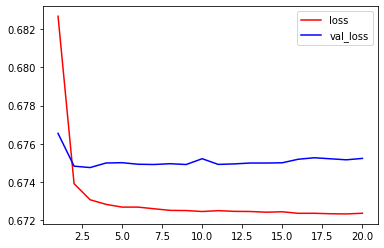

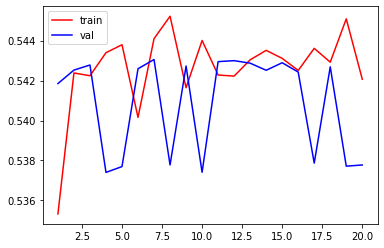

In [246]:
import matplotlib.pyplot as plt

plt.plot(range(1,21), history_dense.history['loss'], 'r', label='loss')
plt.plot(range(1,21), history_dense.history['val_loss'], 'b', label='val_loss')
plt.legend()
plt.show()

plt.plot(range(1,21), history_dense.history['accuracy'], 'r', label='train')
plt.plot(range(1,21), history_dense.history['val_accuracy'], 'b', label='val')
plt.legend()
plt.show()

### Conv1d Net

In [222]:
def get_conv_model(input_shape, voca_size, word_vector_dim):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Embedding(voca_size, word_vector_dim, input_shape=(None, ))(inputs)
    x = keras.layers.Conv1D(16,5,activation='relu')(x)
    x = keras.layers.MaxPooling1D(3)(x)
    x = keras.layers.Conv1D(16, 5, activation='relu')(x)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x =keras.layers.Dense(8, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs,outputs)

In [228]:
conv_model = get_conv_model(input_shape, voca_size, word_vector_dim)
conv_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 37, 16)            1296      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 16)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 8, 16)             1296      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136 

In [229]:
conv_model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [230]:
history = conv_model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs = 20,
    batch_size=256
)

Epoch 1/20
457/457 [==============================] - 3s 5ms/step - loss: 0.4573 - accuracy: 0.7784 - val_loss: 0.3730 - val_accuracy: 0.8330
Epoch 2/20
457/457 [==============================] - 2s 5ms/step - loss: 0.3296 - accuracy: 0.8567 - val_loss: 0.3574 - val_accuracy: 0.8413
Epoch 3/20
457/457 [==============================] - 2s 5ms/step - loss: 0.2915 - accuracy: 0.8759 - val_loss: 0.3622 - val_accuracy: 0.8411
Epoch 4/20
457/457 [==============================] - 2s 5ms/step - loss: 0.2570 - accuracy: 0.8942 - val_loss: 0.3696 - val_accuracy: 0.8415
Epoch 5/20
457/457 [==============================] - 2s 5ms/step - loss: 0.2215 - accuracy: 0.9125 - val_loss: 0.3957 - val_accuracy: 0.8403
Epoch 6/20
457/457 [==============================] - 2s 5ms/step - loss: 0.1865 - accuracy: 0.9290 - val_loss: 0.4357 - val_accuracy: 0.8314
Epoch 7/20
457/457 [==============================] - 2s 5ms/step - loss: 0.1553 - accuracy: 0.9428 - val_loss: 0.4895 - val_accuracy: 0.8306
Epoch 

In [238]:
results = conv_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.2357 - accuracy: 0.8082
[1.2356936931610107, 0.8081859946250916]


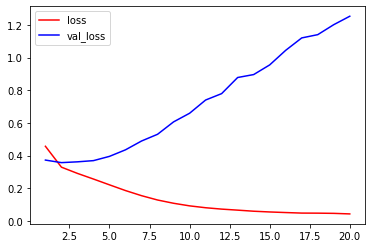

In [232]:
plt.plot(range(1,21), history.history['loss'], 'r', label='loss')
plt.plot(range(1,21), history.history['val_loss'], 'b', label='val_loss')
plt.legend()
plt.show()

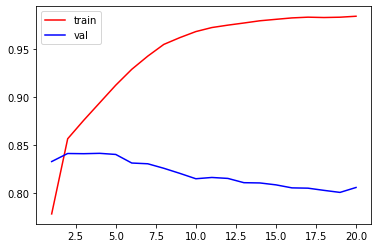

In [233]:
plt.plot(range(1,21), history.history['accuracy'], 'r', label='train')
plt.plot(range(1,21), history.history['val_accuracy'], 'b', label='val')
plt.legend()
plt.show()

### lstm

In [234]:
def get_lstm_model(input_shape, voca_size, word_vector_dim):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Embedding(voca_size, word_vector_dim, input_shape=(None, ))(inputs)
    x = keras.layers.LSTM(8)(x)
    x =keras.layers.Dense(8, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs,outputs)

In [235]:
lstm_model = get_lstm_model(input_shape, voca_size, word_vector_dim)
lstm_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [236]:
lstm_model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_lstm = lstm_model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs = 20,
    batch_size=256
)

Epoch 1/20
457/457 [==============================] - 10s 7ms/step - loss: 0.4434 - accuracy: 0.7979 - val_loss: 0.3657 - val_accuracy: 0.8399
Epoch 2/20
457/457 [==============================] - 2s 5ms/step - loss: 0.3324 - accuracy: 0.8593 - val_loss: 0.3545 - val_accuracy: 0.8463
Epoch 3/20
457/457 [==============================] - 2s 5ms/step - loss: 0.3092 - accuracy: 0.8702 - val_loss: 0.3523 - val_accuracy: 0.8469
Epoch 4/20
457/457 [==============================] - 2s 5ms/step - loss: 0.2908 - accuracy: 0.8782 - val_loss: 0.3509 - val_accuracy: 0.8488
Epoch 5/20
457/457 [==============================] - 2s 5ms/step - loss: 0.2724 - accuracy: 0.8867 - val_loss: 0.3630 - val_accuracy: 0.8473
Epoch 6/20
457/457 [==============================] - 2s 5ms/step - loss: 0.2551 - accuracy: 0.8939 - val_loss: 0.3653 - val_accuracy: 0.8473
Epoch 7/20
457/457 [==============================] - 2s 5ms/step - loss: 0.2386 - accuracy: 0.9014 - val_loss: 0.3750 - val_accuracy: 0.8473
Epoch

In [240]:
results = lstm_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6014 - accuracy: 0.8316
[0.6013917922973633, 0.8316007852554321]


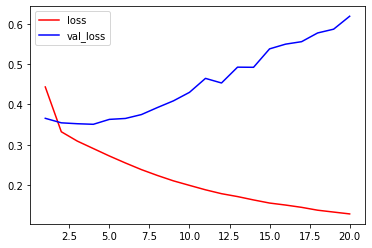

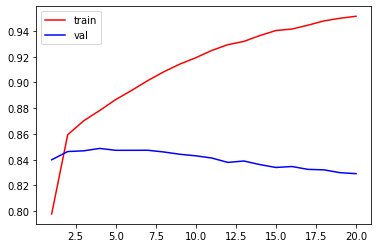

In [237]:
plt.plot(range(1,21), history_lstm.history['loss'], 'r', label='loss')
plt.plot(range(1,21), history_lstm.history['val_loss'], 'b', label='val_loss')
plt.legend()
plt.show()

plt.plot(range(1,21), history_lstm.history['accuracy'], 'r', label='train')
plt.plot(range(1,21), history_lstm.history['val_accuracy'], 'b', label='val')
plt.legend()
plt.show()